In [245]:
import best

In [246]:
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

In [247]:
import numpy as np

In [248]:
import pathlib

In [249]:
import yaml

In [250]:
import utilities as u
import itertools

### Basic data

In [251]:
values_file = 'configurations/configILC.yaml'
with open(values_file, 'r') as stream:
    data = yaml.safe_load(stream)

In [252]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

colors = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]
    colors += [estimators_dictionary[e]['color']]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [253]:
lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [254]:
invvariance = data['optimisation']['inv_variances']
invvariance = bool(invvariance[0])

### Some utility function

In [255]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [256]:
def modify_est_weights(Opt, index, x, l_index, newvalue):
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    x = x.copy()
    x[index+Nest*l_index] = newvalue
    return x

In [257]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [258]:
def get_info(directory, resultspath, fb = 1.0):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/f'w_auto_fb_{fb}.npy')
    x = np.load(resultspath/directory/f'x_auto_fb_{fb}.npy')
    return kk, theta, ells, biases, noises, w, x

In [259]:
def get_dir_function(names):
    def get_dir_(*vals):
        stringa = ''
        for i, k in enumerate(names.keys()):
            num = vals[i]
            v = names[k]
            stringa += f'{v}{num}'
        return stringa
    return get_dir_

### Work on one config

In [260]:
get_dir = get_dir_function(names)

In [325]:
lmax_directory = get_dir(4500, 3500, 4000, 4000)
resultspath = pathlib.Path(results_directory)
fb = 16.
lmax_directory

's4500b3500p4000sy4000'

In [262]:
kk, theta, ells, biases, noises, w, x = get_info(lmax_directory, resultspath, fb = fb)
Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)

In [263]:
resultkk = best.Res()
f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)

In [314]:
nn = np.identity(self.noises_selected.shape[0])[..., None]*Optimizerkk.noises_selected

In [315]:
nn[..., 0]

array([[1.53482871e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.51157258e-08, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.45869975e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.28449862e-08]])

In [ ]:
Optimizerkk.noises_selected

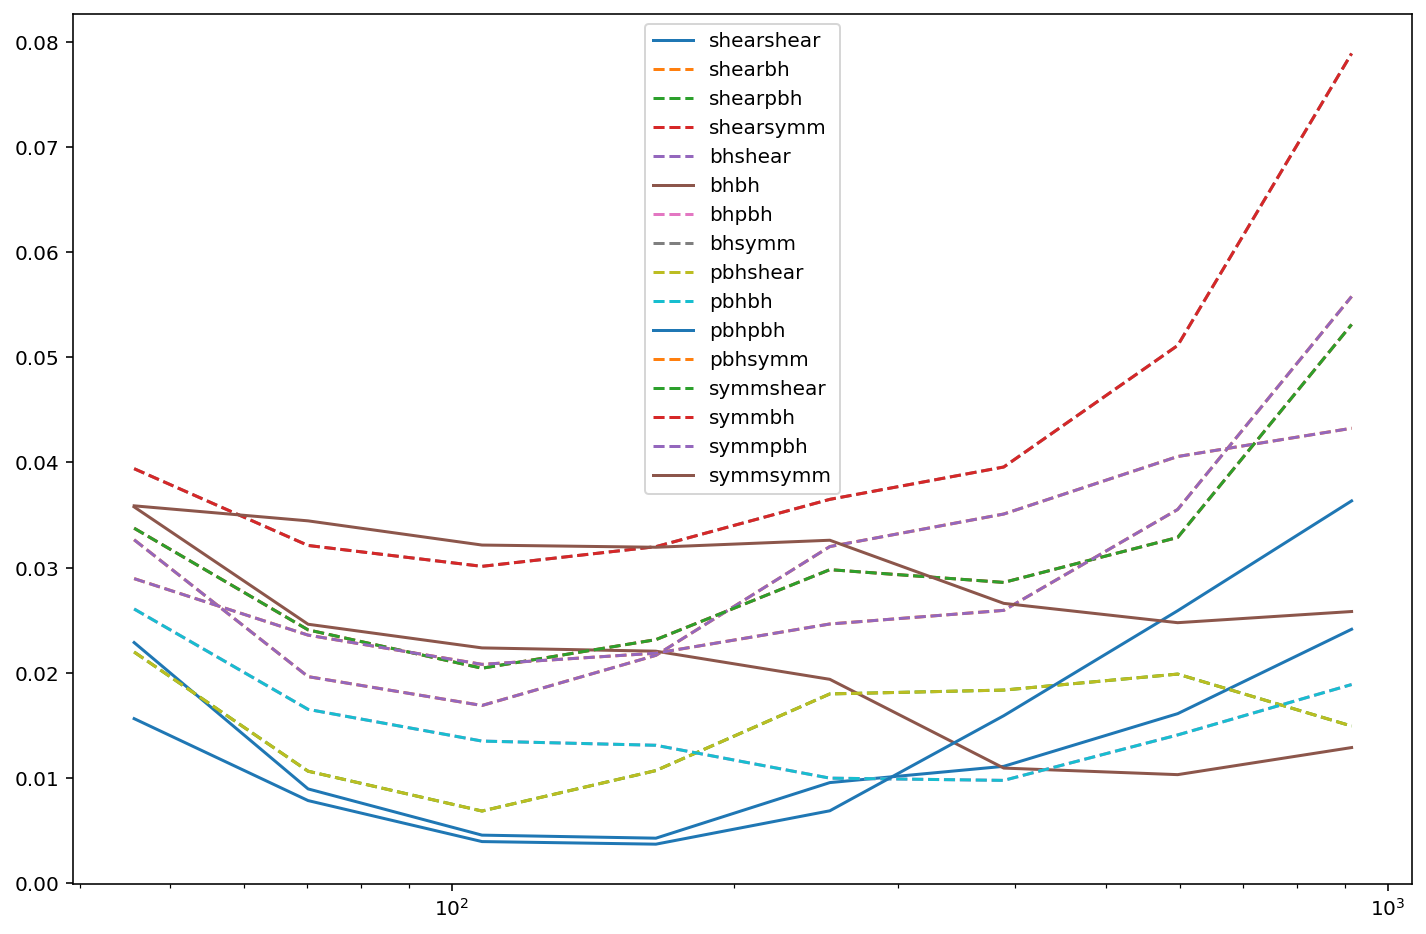

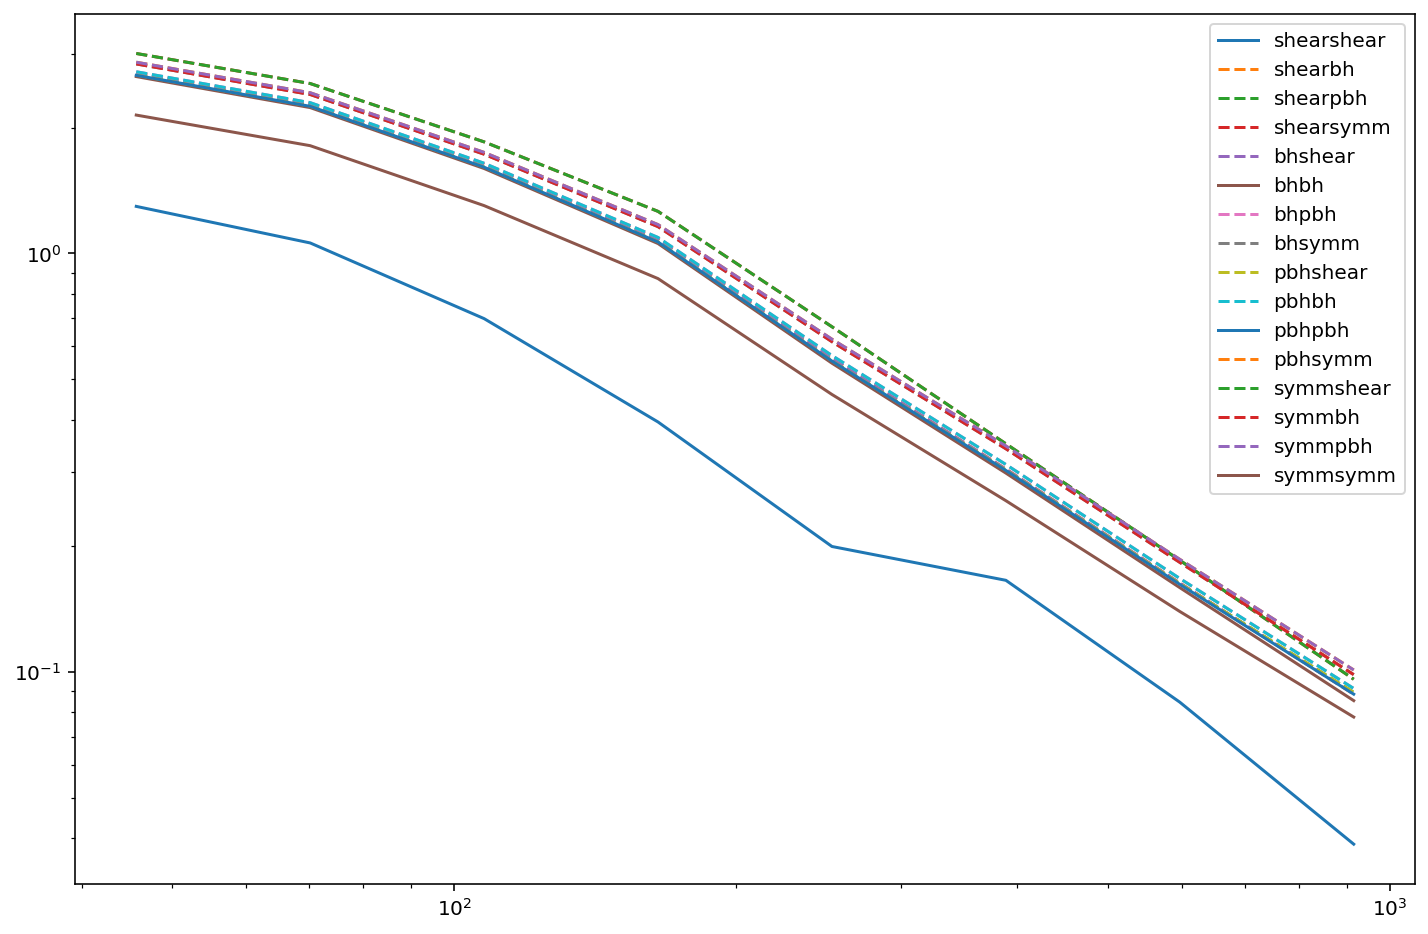

In [293]:
filtered = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
for i in range(Optimizerkk.Ne):
    for j in range(Optimizerkk.Ne):
        thetacurve = filtered[i, j]/Optimizerkk.theory_selected
        ls = '-' if i == j else '--'
        plt.plot(Optimizerkk.ells_selected, thetacurve, label = estimators[i]+estimators[j], ls = ls)
plt.xscale('log')
plt.legend()
plt.show()

for i in range(Optimizerkk.Ne):
    for j in range(Optimizerkk.Ne):
        thetacurve = Optimizerkk.noises_selected[i, j]/Optimizerkk.theory_selected
        ls = '-' if i == j else '--'
        plt.plot(Optimizerkk.ells_selected, thetacurve**-1., label = estimators[i]+estimators[j], ls = ls)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [337]:
def plotuseful(fb, Opt, result, invvariance):
    

    result.load_all(resultspath/lmax_directory, f'auto_fb_{fb}')

    a = Opt.get_a(result.x, invvariance)
    
    wl = result.ws[:, -1]

    fig, axs = plt.subplots(nrows = 6, sharex = True)

    fig.suptitle(f'$f_b$ = {fb}')
    
    filtered = Opt.filter_(abs(Opt.biases_selected), sigma = 1.5)
    
    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, filtered, Opt.noises_selected)
    
    f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(result.x), n(result.x), b(result.x)
    
    combinedb_abs = Optimizerkk_abs.get_bias_part(a, filtered)
    combinedb_abs = wl*combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected*fb
    
    combinedtheta = wl**2*Optimizerkk_abs.get_variance_part(a, Optimizerkk_abs.theta_selected)/Optimizerkk_abs.theory_selected**2.
    
    
    
    axs[3].plot(Opt.ells_selected, combinedtheta, color = 'gold', label = 'Combined Var')
    axs[3].plot(Opt.ells_selected, combinedb_abs, color = 'silver', label = 'Combined Bias')
    
    for index in range(Opt.Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        variance = True
        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        #print(f'Example is for {Optimizerkk.estimators[index]}')
        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        
        axs[2].plot(Opt.ells_selected, wl_example**2*(theta_example/Optimizerkk_abs.theory_selected**2)+wl_example*combinedb_abs_example, color = colors[index], ls = ':')

    for i in range(Opt.Ne):
        biascurve = abs(Opt.biases_selected[i, i])/Opt.theory_selected
        axs[0].plot(Opt.ells_selected, biascurve, label = estimators[i], color = colors[i])
        thetacurve = Opt.theory_selected**2./Opt.theta_selected[i, i, i, i]
        #for j in range(i, 3):
        #    thetacurve = filtered[i, j]/Optimizerkk.theory_selected
        #    axs[1].plot(Opt.ells_selected, thetacurve)
        axs[1].plot(Opt.ells_selected, Opt.filter_(abs(Opt.biases_selected), sigma = 1.5)[i, i]/Optimizerkk.theory_selected, color = colors[i])

        axs[4].plot(Opt.ells_selected, a[:, i], color = colors[i])

    axs[-1].plot(Opt.ells_selected, wl, color = 'black')
        
    axs[0].legend(ncol = Opt.Ne)
    axs[3].legend(ncol = 2)
    axs[3].set_yscale('log')
    axs[2].set_yscale('log')
    
    axs[1].set_xscale('log')
    #axs[1].set_yscale('log')
    axs[0].set_ylabel('abs B')
    axs[1].set_ylabel('filt abs B')
    axs[4].set_ylabel('W')
    axs[-1].set_ylabel('Wl')
    
    plt.show()
    
    return a

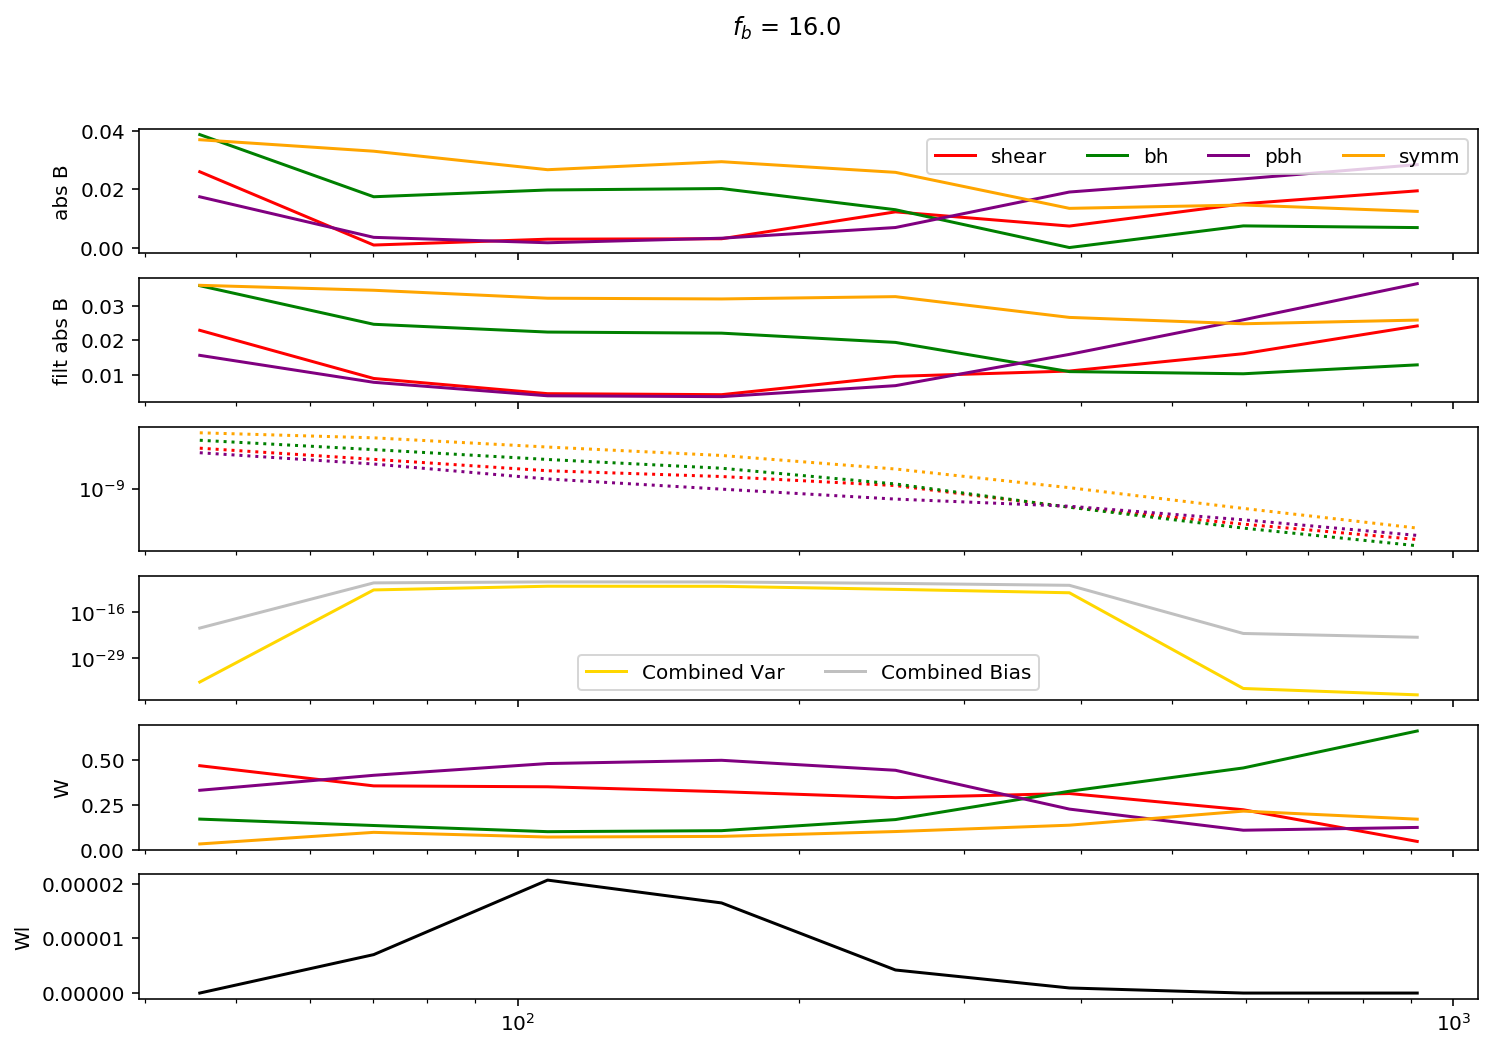

In [338]:
a = plotuseful(fb, Optimizerkk, resultkk, invvariance)

In [318]:
Optimizerkk.ells_selected

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [320]:
a = a.copy()
a[0]

array([0.46798509, 0.16997547, 0.3307674 , 0.03127204])

In [321]:
lselected = Optimizerkk.ells_selected[0]
l_index = list(Optimizerkk.ells_selected).index(lselected)
newx = modify_est_weights(Optimizerkk, 0, resultkk.x, l_index, a[0][2])
newx = modify_est_weights(Optimizerkk, 2, newx, l_index, a[0][0])
aa = Optimizerkk.get_a(newx, invvariance)
aa

array([[0.3307674 , 0.16997547, 0.46798509, 0.03127204],
       [0.35535672, 0.13420825, 0.41445351, 0.09598151],
       [0.35029325, 0.09983828, 0.48001879, 0.06984968],
       [0.32295276, 0.10543069, 0.49818705, 0.07342949],
       [0.28975213, 0.16731108, 0.44241982, 0.10051697],
       [0.31274743, 0.32545482, 0.22583847, 0.13595928],
       [0.22210201, 0.4554656 , 0.10787911, 0.21455329],
       [0.04527901, 0.66167148, 0.12349452, 0.16955499]])

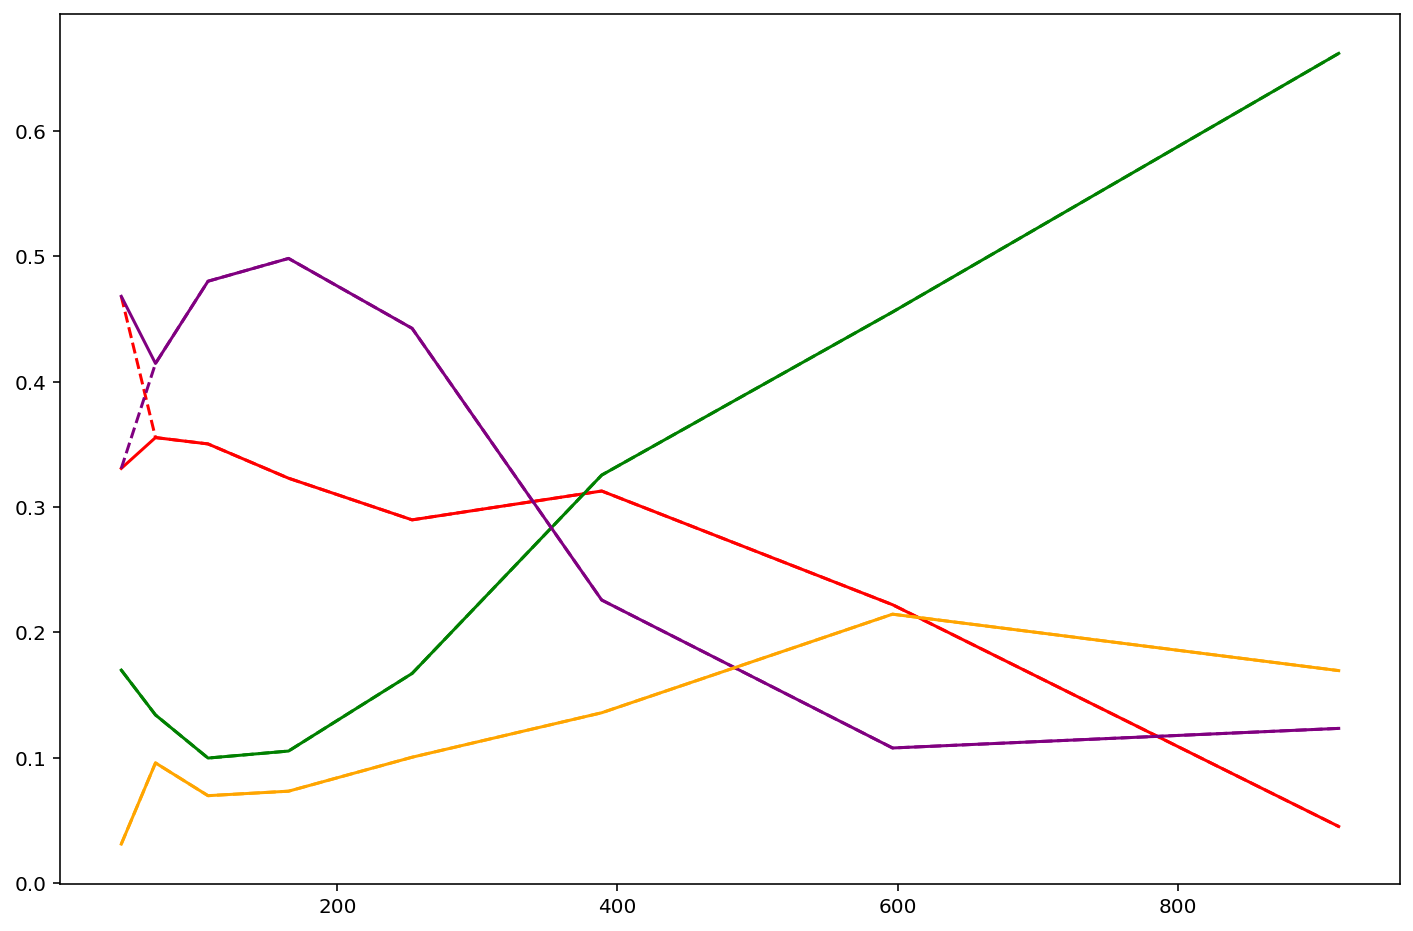

In [322]:
for i in range(Optimizerkk.Ne):
    plt.plot(Optimizerkk.ells_selected, aa[:, i], color = colors[i])
    plt.plot(Optimizerkk.ells_selected, a[:, i], color = colors[i], ls = '--')

In [324]:
resultkk.x/newx

array([1.41484649, 1.        , 0.70679046, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [323]:
f(resultkk.x)/f(newx)

1.0

### Check noise

In [202]:
from pixell import enmap, utils as putils

In [187]:
matrix = np.rollaxis(Optimizerkk.noises_selected, 2)
Ninv = np.linalg.inv(matrix)
e = np.ones(Optimizerkk.Ne)
prod = Ninv.dot(e)
doubleprod = e.T@prod.T
weights = prod/doubleprod[:, None]
weights

array([[ 0.99701602, -0.07306581,  0.07604979],
       [ 0.99544557, -0.07347063,  0.07802506],
       [ 0.99085637, -0.074373  ,  0.08351663],
       [ 0.98157964, -0.07508943,  0.09350978],
       [ 0.96622093, -0.07478689,  0.10856596],
       [ 0.95482292, -0.07395498,  0.11913207],
       [ 0.94496273, -0.07216096,  0.12719823],
       [ 0.93229161, -0.07333891,  0.1410473 ]])

In [190]:
estimatorcombs = list(itertools.combinations_with_replacement(list(estimators), 2))
estimatorcombs

[('bh', 'bh'),
 ('bh', 'pbh'),
 ('bh', 'symm'),
 ('pbh', 'pbh'),
 ('pbh', 'symm'),
 ('symm', 'symm')]

In [238]:
estimatorcombs_selected = estimatorcombs#[('bh', 'bh'), ('bh', 'symm'), ('symm', 'symm')]

In [239]:
lmaxes_dict = {}
lmaxes_dict['bh'] = 4500
lmaxes_dict['pbh'] = 3500
lmaxes_dict['symm'] = 4000
lmin_A, lmin_B = 30, 30
Lmin, Lmax = 10, 6000

In [240]:
noise_dict = {}

for estA, estB in estimatorcombs_selected:
    print(estA, estB)

    C = u.Converting()
    
    nuA = estimators_dictionary[estA]['nu']
    nuB = estimators_dictionary[estB]['nu']
    #print(nuA, nuB)
    lmax_A = lmaxes_dict[estA]
    lmax_B = lmaxes_dict[estB]

    mapsObjA = u.mapNamesObj(nuA)
    mapsObjB = u.mapNamesObj(nuB)

    hardening_A = estimators_dictionary[estA]['hardening']
    hardening_B = estimators_dictionary[estB]['hardening']

    #field_names_A = ['A1', 'A2']
    #field_names_B = ['B1', 'B2']

    field_names_A = estimators_dictionary[estA]['field_names']
    field_names_B = estimators_dictionary[estB]['field_names']


    tszprofileA = estimators_dictionary[estA]['tszprofile']
    tszprofileB = estimators_dictionary[estB]['tszprofile']
    tszprofile_A = None if tszprofileA == '' else 1.
    tszprofile_B = None if tszprofileB == '' else 1.

    changemap = lambda x: enmap.enmap(x, wcs)
    #Load maps for Leg1, Leg2 for estimator A
    LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_A)
    #Leg1, Leg2, for estimator B
    LoadB = u.LoadfftedMaps(mapsObj = mapsObjB, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft, lmax = lmax_B) 

    estimator_to_harden_A = 'hu_ok' if (estA in ['bh', 'pbh']) else estA
    estimator_to_harden_B = 'hu_ok' if (estB in ['bh', 'pbh']) else estB

    #MAYBE JUST ADD esttohard in yaml config

    estimator_to_harden_A = 'symm' if ('symm' in estA) else estimator_to_harden_A #in ['symmbh', 'symmpbh']) else estA
    estimator_to_harden_B = 'symm' if ('symm' in estB) else estimator_to_harden_B #(estB in ['symmbh', 'symmpbh']) else estB

    #Get shape and wcs
    shape = LoadA.read_shape()
    lonCenter, latCenter = 0, 0
    shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
    modlmap = enmap.modlmap(shape, wcs)
    #Binner
    #Binner = u.Binner(shape, wcs, lmin = 10, lmax = 4000, deltal = deltal, log = logmode, nBins = nlogBins)
    Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)
    
    if estA == 'bh': 
        field_names_A = ['ilc', 'ilc']
        
    if estB == 'bh': 
        field_names_B = ['ilc', 'ilc']

    feed_dict = u.Loadfeed_dict(pathlib.Path(spectra_path), field_names_A, field_names_B, modlmap, hardening_A, hardening_B, tszprofile_A, tszprofile_B)

    #NOTE, THIS SHOULD BE OUTSIDE THE IF
    #BUT IF iMax = iMin+1 , then it should be fine, will make code a bit faster
    #So this is fine as long as the number of processes is such that the above relation is ok
    #Estimator objects
    
    A = u.Estimator(shape, wcs, feed_dict, estA, lmin_A, lmax_A,
                    field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
                    hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT') 
    
    print(field_names_A, field_names_B)
    
    B = u.Estimator(shape, wcs, feed_dict, estB, lmin_B, lmax_B,
                    field_names = field_names_B, groups = None, Lmin = Lmin, Lmax = Lmax,
                    hardening = hardening_B, estimator_to_harden = estimator_to_harden_B, XY = 'TT')


    NAB_cross = A.get_Nl_cross_other(feed_dict, B, tipo = 't')
    l, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    
    noise_dict[estA+estB] = NAB_cross_binned
    


bh bh
Read saved
Read saved
['ilc', 'ilc'] ['ilc', 'ilc']
Read saved
Read saved
bh pbh
Read saved
Read saved
['ilc', 'ilc'] ['ilcA', 'ilcB']
Read saved
Read saved
bh symm
Read saved
Read saved
['ilc', 'ilc'] ['ilc', 'ilcdepr']


/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:532: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:533: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:545: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


pbh pbh
Read saved
Read saved
['ilcA', 'ilcB'] ['ilcA', 'ilcB']
Read saved
Read saved
pbh symm
Read saved
Read saved
['ilcA', 'ilcB'] ['ilc', 'ilcdepr']


/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:532: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:533: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:545: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


symm symm


/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:532: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:533: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:545: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


['ilc', 'ilcdepr'] ['ilc', 'ilcdepr']


/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:532: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:533: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:545: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


In [241]:
D = u.Estimator(shape, wcs, feed_dict, 'symm', lmin_A, 4500,
                field_names = ['ilc', 'ilcdepr'], groups = None, Lmin = Lmin, Lmax = Lmax,
                hardening = None, estimator_to_harden = 'hu_ok', XY = 'TT') 

/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:532: RuntimeWarning: invalid value encountered in true_divide
  w_E1_E2 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:533: RuntimeWarning: invalid value encountered in true_divide
  w_E2_E1 /= w
/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:545: RuntimeWarning: invalid value encountered in true_divide
  coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w


In [234]:
feed_dict['pcsrcbh_T_T'] = 1.

A = u.Estimator(shape, wcs, feed_dict, 'bh', lmin_A, 4500,
                field_names = ['ilc', 'ilc'], groups = None, Lmin = Lmin, Lmax = Lmax,
                hardening = 'srcbh', estimator_to_harden = 'hu_ok', XY = 'TT') 

B = u.Estimator(shape, wcs, feed_dict, 'hdv', lmin_A, 4000,
                field_names = ['ilcdepr', 'ilc'], groups = None, Lmin = Lmin, Lmax = Lmax,
                hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT') 

C = u.Estimator(shape, wcs, feed_dict, 'hdv', lmin_A, 4000,
                field_names = ['ilc', 'ilcdepr'], groups = None, Lmin = Lmin, Lmax = Lmax,
                hardening = hardening_A, estimator_to_harden = estimator_to_harden_A, XY = 'TT') 

Read saved
Read saved


In [235]:
NAB_cross = A.get_Nl_cross_other(feed_dict, B, tipo = 't')
l, NAB_cross_binned = Binner.bin_spectra(NAB_cross)    

NAC_cross = A.get_Nl_cross_other(feed_dict, C, tipo = 't')
l, NAC_cross_binned = Binner.bin_spectra(NAC_cross) 

NBB = B.get_Nl_cross_other(feed_dict, B, tipo = 't')
l, NBB_cross_binned = Binner.bin_spectra(NBB) 
NCC = C.get_Nl_cross_other(feed_dict, C, tipo = 't')
l, NCC_cross_binned = Binner.bin_spectra(NCC) 
NBC = B.get_Nl_cross_other(feed_dict, C, tipo = 't')
l, NBC_cross_binned = Binner.bin_spectra(NBC) 

In [236]:
wB, wC = u.getasymmweights(NBB_cross_binned, NCC_cross_binned, NBC_cross_binned)
NN = wB*NAB_cross_binned+wC*NAC_cross_binned

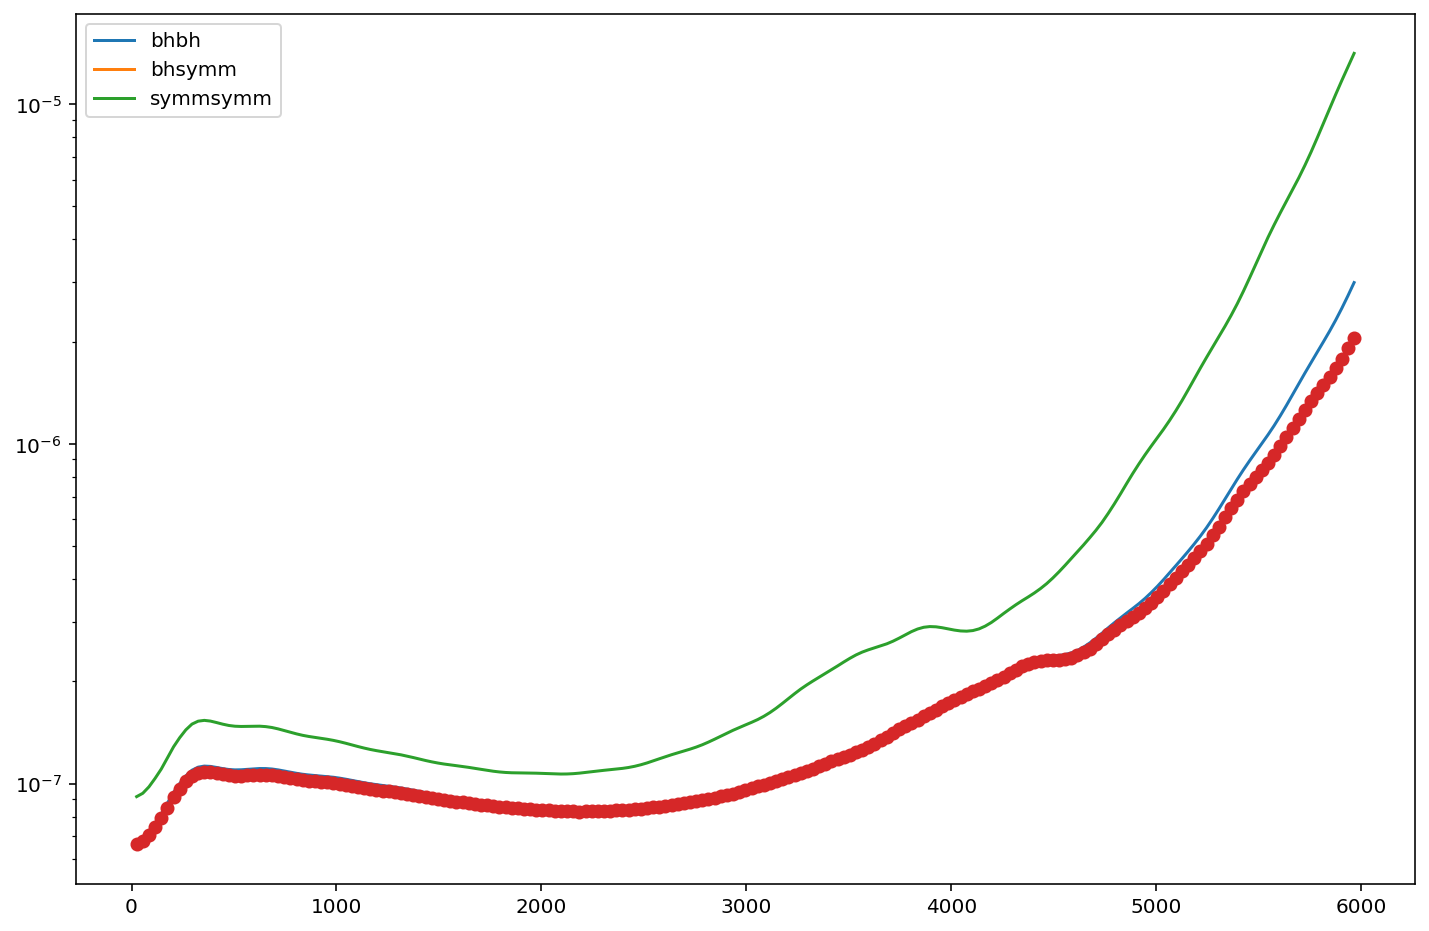

In [237]:
for k, v in noise_dict.items():
    plt.plot(l ,v, label = k)
    
plt.plot(l, NN, marker = 'o')
plt.legend()
plt.yscale('log')

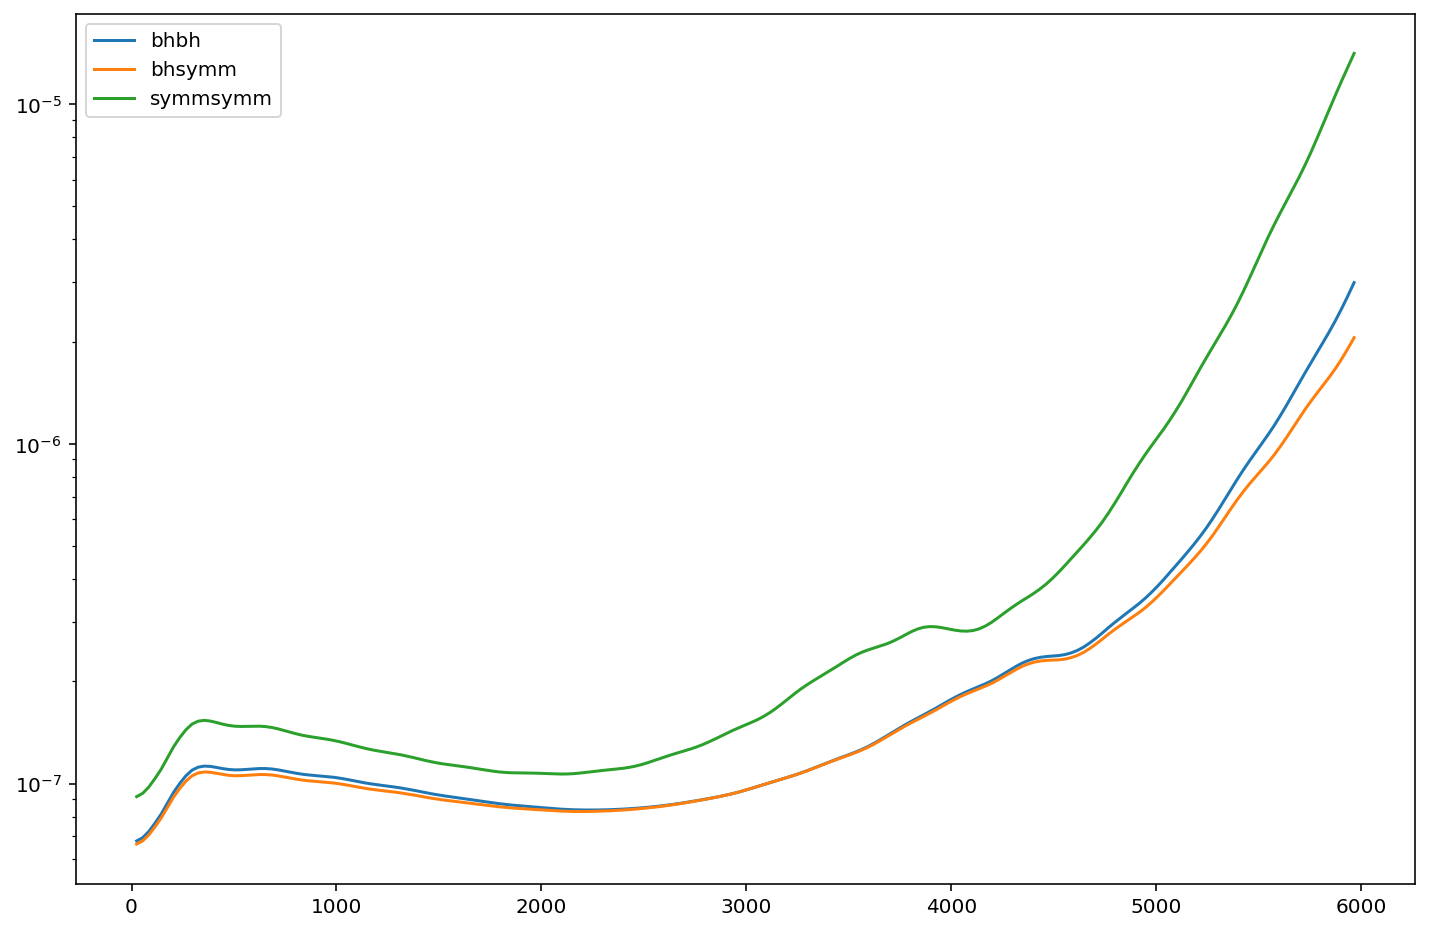

In [212]:
for k, v in noise_dict.items():
    plt.plot(l ,v, label = k)
plt.legend()
plt.yscale('log')

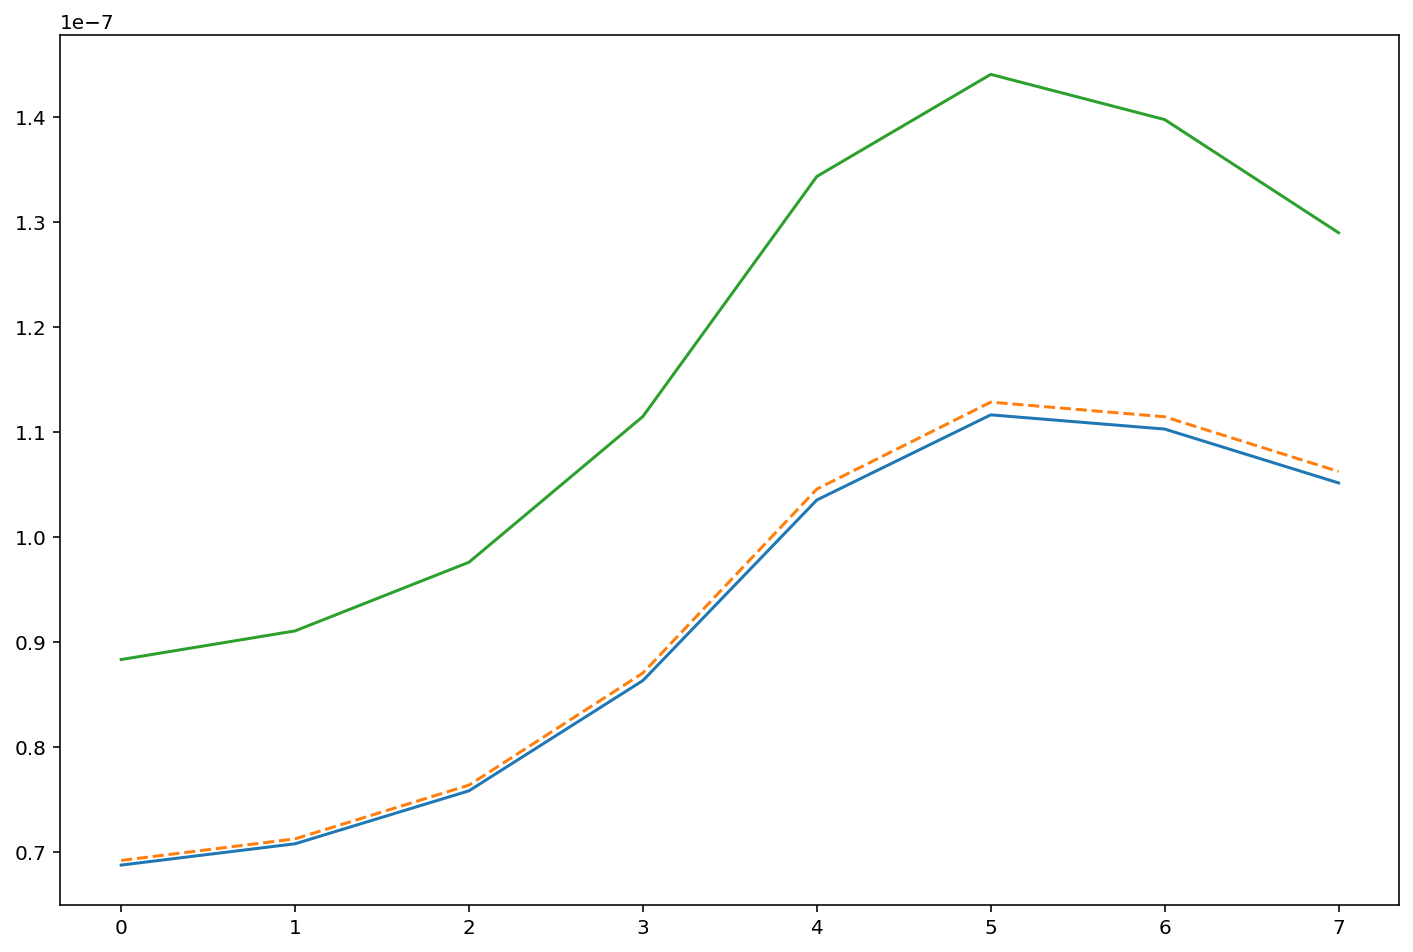

In [188]:
plt.plot(Optimizerkk.noises_selected[0, 0])
plt.plot(Optimizerkk.noises_selected[0, 1], ls = '--')
plt.plot(Optimizerkk.noises_selected[2, 2])

In [186]:
weights

array([[ 0.99701602, -0.07306581,  0.07604979],
       [ 0.99544557, -0.07347063,  0.07802506],
       [ 0.99085637, -0.074373  ,  0.08351663],
       [ 0.98157964, -0.07508943,  0.09350978],
       [ 0.96622093, -0.07478689,  0.10856596],
       [ 0.95482292, -0.07395498,  0.11913207],
       [ 0.94496273, -0.07216096,  0.12719823],
       [ 0.93229161, -0.07333891,  0.1410473 ]])